# Quantum Support Vector Machines

In [1]:
from IPython.display import clear_output
!pip install qiskit
!pip install qiskit_machine_learning
!pip install pylatexenc
clear_output()

In [2]:
# General imports:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Qiskit imports:
import qiskit

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

In [4]:
# Scikit learn imports:
from sklearn import datasets  #Houses a bunch of datasets.
from sklearn.model_selection import train_test_split  #Splits the data set into training and test set.
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Two types of scaling or regularizing (Standard ==> N(0,1)).
from sklearn.decomposition import PCA #We are going to use PCA for dimensionality reduction.
from sklearn.svm import SVC #The suppor vector classifier with a regularization parameter C
from sklearn.metrics import accuracy_score  #To determine the accuracy at the end.

In [5]:
# Data preperation:
import tensorflow
from tensorflow.keras.datasets import mnist
(X_tr, Y_tr),(X_te,Y_te) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [6]:
x_train = []
y_train = []
for i in range(len(Y_tr)):
    if Y_tr[i]== 4 or Y_tr[i]== 9:
        x_train.append(X_tr[i].flatten())
        y_train.append(Y_tr[i])


x_test = []
y_test = []
for i in range(len(Y_te)):
    if Y_te[i]== 4 or Y_te[i]== 9:
        x_test.append(X_te[i].flatten())
        y_test.append(Y_te[i])

X_train = np.array(x_train)
Y_train = np.array(y_train)
X_test = np.array(x_test)
Y_test = np.array(y_test)

In [7]:
print("The shape of X_train is: ", X_train.shape)
print("The shape of Y_train is: ", Y_train.shape)
print("The shape of X_test is: ", X_test.shape)
print("The shape of Y_test is: ", Y_test.shape)

The shape of X_train is:  (11791, 784)
The shape of Y_train is:  (11791,)
The shape of X_test is:  (1991, 784)
The shape of Y_test is:  (1991,)


In [8]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

To get a visual confirmation of our image data, let us see an example:

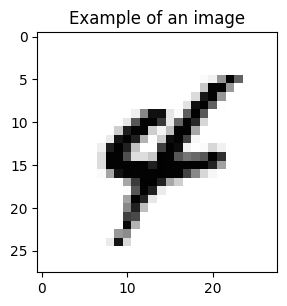

In [9]:
# Data point:  (point chosen at random from X_test)
x1 = (X_train[34]).reshape((28,28))

# Creating the plot:
pixel_plot = plt.figure()

# Plotting the plot
pixel_plot.add_axes([1,0.5,1,0.5])

# Title and configurations
plt.title("Example of an image")
pixel_plot = plt.imshow(x1, cmap = "Greys")

### Data Pre-processing:

- We standarize the dataset with zero-mean and unit-variance.
- Then we use PCA to reduce the dimensionality to 5. (Dimensionality here is a hyperparameter.)
- Then we scale the features such that their values have a range from -1 to +1 (Normalization)

In [10]:
# Standardize
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [11]:
# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [12]:
# Normalize
mms = MinMaxScaler((-1, 1))
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

Dimensionally reduced data looks like:

In [13]:
print("First training data: ", X_train[0])

First training data:  [-0.0047542  -0.18336757  0.08715205  0.03329919 -0.20114368]


With that our data is ready for use.

### Data Encoding:

How to represent or efficiently input the data into a quantum system, so that it could be processed by a quantum machine learning algorithm. This is usually referred to as data encoding, but is also called data embedding or loading. Some basic methods are as follows:

1. Basis encoding: We represent the numerical values as bit strings and superpose all the values.
- Adv: Easy to understand
- Dis. Adv: Sparse statevectors in most cases

2. Amplitude encoding: All the m examples' n feature values are stored as amplitudes of the basis states
- Adv: We only need log(mn) qubits
- Dis. Adv: Working with algorithms that work on amplitudes is a rather tedious process considering issues with measurements

3. Angle encoding: Here the N features of a given x are encodes as rotation angles of the n qubits.
- Adv: One data point at a time and N qubits required and constant depth ansatz
- Dis adv: Nothing special about these functions. We can easily abstract these to a general class of qubit encodings that use arbitrary functions, or define the encodings as arbitrary unitaries, implemented as parameterized quantum circuits.



So lets go with a sort of angle encoding:
- Now is where we get the "quantum advantage!".
- This basically is the representation of classical data on qubits using parametrized quantum circuits.
- Parametrized circuits have 3 features: Expressibility, Entangling Capability and Hardware effeciency.
- Expressibility is about how much of Hilbert space can be covered using the Ansatz.
- Entagling capabilities are considered because it should be hard to simulate on a classical computer.
- Hardware effeciency is a matter of concern considering that we live in the NISQ era.

The parametrized Quantum Circuits can be thought of as unitary transformations. This should ring a lot of bells because, even in classical SVMs, we use feature maps $\phi(x)$ to map $x \in X \to \phi(x)$ which lies in the higher dimensional space. So we may use these unitaries to map our data to the n - dimensional Hilbert space. This is what we shall call a Quantum Feature Map.

As the name suggests, a quantum feature map  is a map from the classical feature vector $x$ to the quantum state $|\Phi(x)\rangle\langle\Phi(x)|$. This is facilitated by applying the unitary operation
 on the initial state
 where n is the number of qubits being used for encoding.

We shall be using qiskit's `PauliFeatureMap` for our example.

The `PauliFeatureMap` has the following important arguments:

```python
PauliFeatureMap(feature_dimension=None, reps=2,
                entanglement='full', paulis=None)
```

and describes the following unitary operator of depth $d$:

$$ \mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},  \\\\\ where\  U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{i\in S} P_i\right), $$

which contains layers of Hadamard gates interleaved with entangling blocks, $U_{\Phi(\mathbf{x})}$, encoding the classical data.

It contains layers of Hadamard gates interleaved with entangling blocks, $U_{\Phi(\mathbf{x})}$. This unitary was chosen because it is classically difficult to compute, but tractable on near term hardware. It would make no sense to have something done on a quantum computer that could be done clasically.

Within the entangling blocks, $U_{\Phi(\mathbf{x})}$: $P_i \in \{ I, X, Y, Z \}$ denotes the Pauli matrices, the index $S$ (in the equation for $U_{\phi(x)}$) describes connectivities between different qubits or datapoints: $S \in \{\binom{n}{k}\ combinations,\ k = 1,... n \}$, and by default the data mapping function $\phi_S(\mathbf{x})$ is
$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$

(here k = 2 because we want kernels to represent the dot product of 2 points)

The code below encodes the first data point in the training examples using the `PauliFeatureMap`. We shall also draw the corresponding circuit.

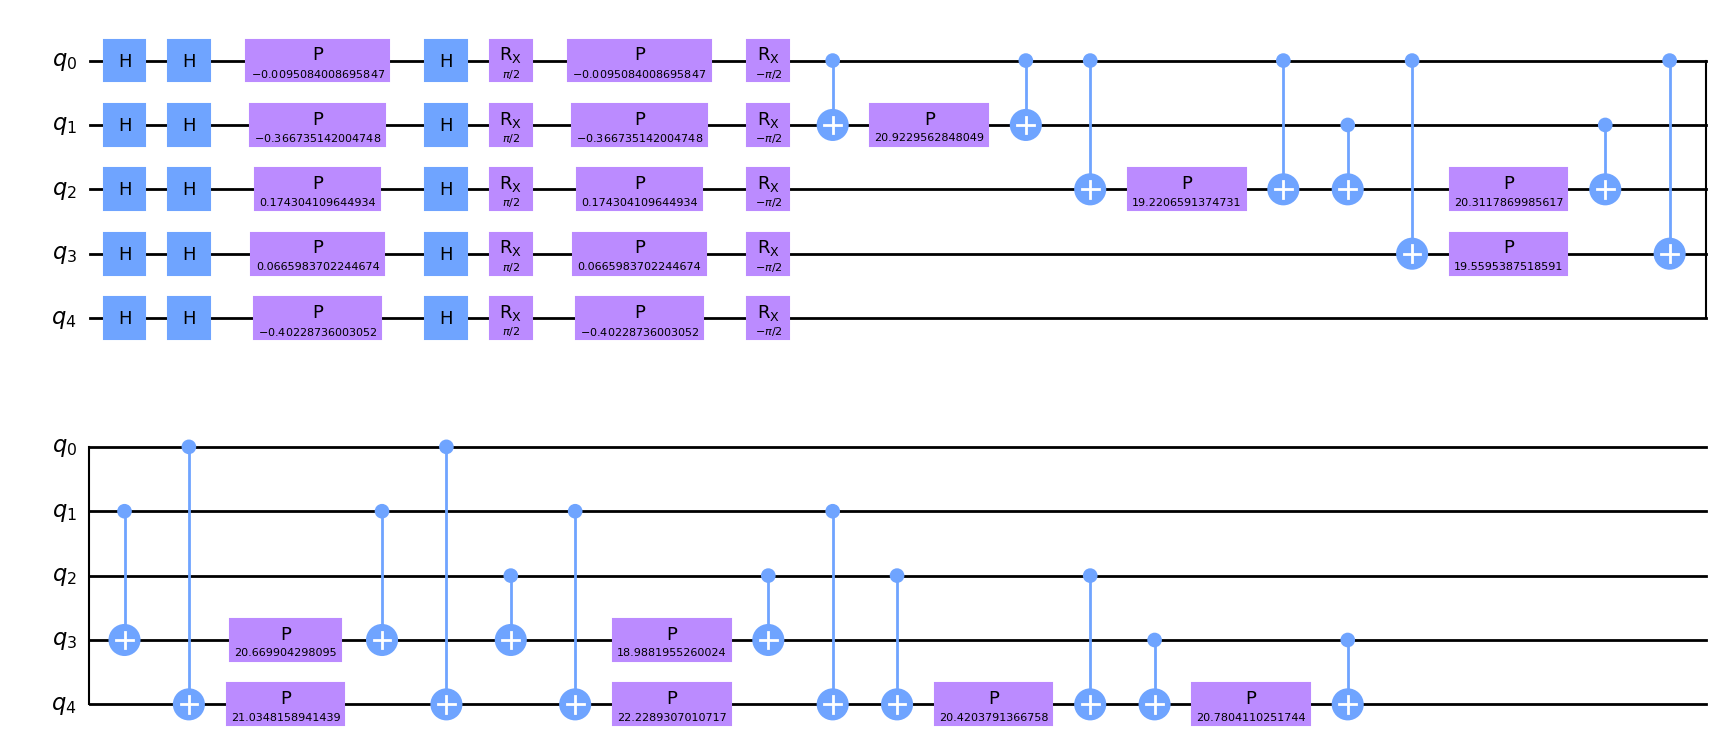

In [14]:
encode_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
encode_circuit = encode_map.bind_parameters(X_train[0])
encode_circuit.decompose().draw(output='mpl')

### Quantum Kernels:

Classically, whenever we have high dimensional spaces to deal with, we look for the dual form of our problem formulation to be able to use the Kernel Trick. But a quantum feature map, $\phi(\mathbf{x})$, naturally gives rise to a quantum kernel, $k(\mathbf{x}_i,\mathbf{x}_j)= \phi(\mathbf{x}_j)^\dagger\phi(\mathbf{x}_i)$.

The Kernel Matrix can then be defined as:
$K_{ij} = \left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2}$.


The elements of this matrix are calculated using what they call a "Transition Amplitude." It is nothing but the dot product of the unitary applied to the all- 0 default initial state ($| 0^{\otimes n} \rangle$).
$$
\left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2} =
\left| \langle 0^{\otimes n} | \mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) | 0^{\otimes n} \rangle \right|^{2}
$$

Why does this work? Hint: try i == j and we'll see that $<\phi(x)^\dagger\phi(x)> = I$ which implies that the unitary corresponding to $x_j$ will *completely* undo the effects of the unitary corresponding to $x_i$. So more similar the data points, more of $| 0^{\otimes n} \rangle$ we get to see (higher amplitude), since similar data implies similar encoding. This is the method we shall be using to estimate the quantum kernel.

Let's try the Quantum Kernel estimation for the similarity between the first 2 training examples:

In [15]:
print('First training data ', X_train[0])
print('Second training data', X_train[1])

First training data  [-0.0047542  -0.18336757  0.08715205  0.03329919 -0.20114368]
Second training data [-0.75017729 -0.53956058 -0.29438497 -0.04620115 -0.02543632]


Now we encode the two points.

In [16]:
pauli_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel = QuantumKernel(feature_map=pauli_map, quantum_instance=Aer.get_backend('statevector_simulator'))

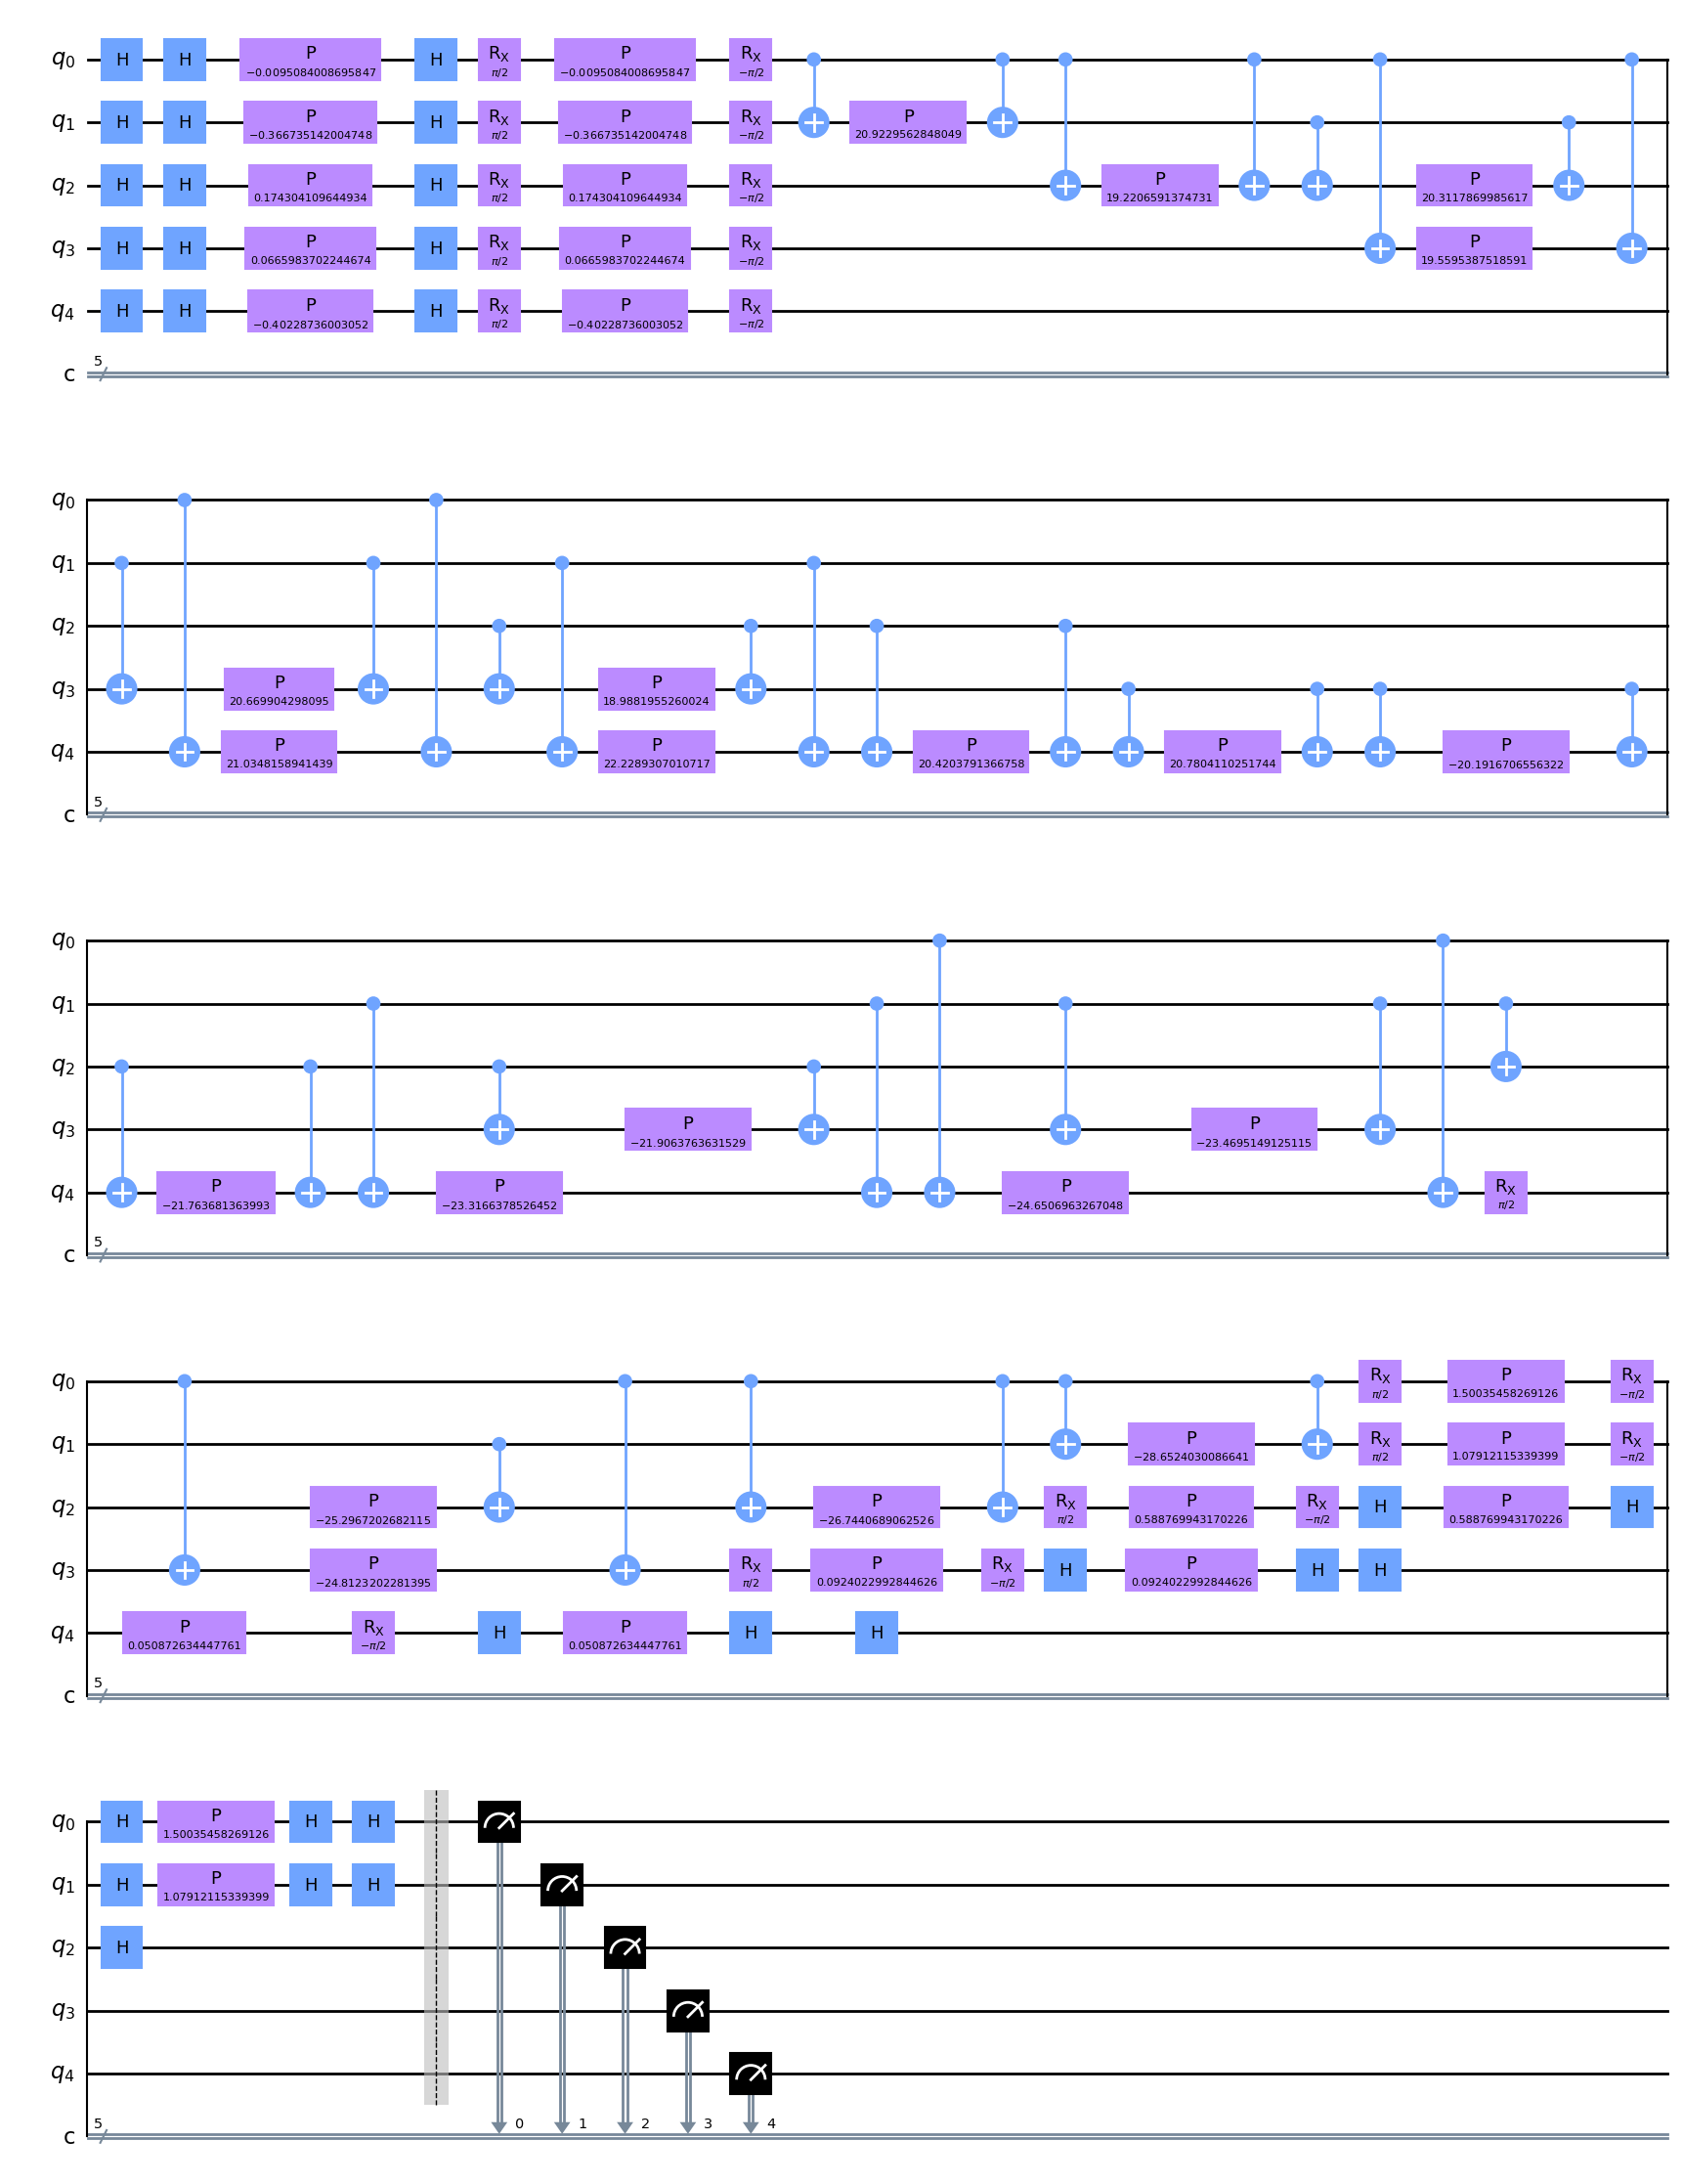

In [17]:
pauli_circuit = pauli_kernel.construct_circuit(X_train[0], X_train[1])
pauli_circuit.decompose().decompose().draw(output='mpl')

### Running the code on a Quantum Simulator:
We compute the dot product.

In [18]:
backend = Aer.get_backend('qasm_simulator')
job = execute(pauli_circuit, backend, shots=8192,
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(pauli_circuit)

In [19]:
print(f"Transition amplitude: {counts['0'*N_DIM]/sum(counts.values())}")

Transition amplitude: 0.036865234375


### The Kernel Matrix:

Now we shall obtain the kernel matrix for the training and test examples.

In [20]:
matrix_train = pauli_kernel.evaluate(x_vec=X_train)
matrix_test = pauli_kernel.evaluate(x_vec=X_test, y_vec=X_train)

In [21]:
pauli_svc = SVC(kernel='precomputed')
pauli_svc.fit(matrix_train, Y_train)
pauli_score = pauli_svc.score(matrix_test, Y_test)

print(f'Precomputed kernel classification test score: {pauli_score*100}%')

Precomputed kernel classification test score: 78.75439477649422%


In [22]:
pauli_svc = SVC(kernel='rbf')
pauli_svc.fit(X_train, Y_train)
pauli_score = pauli_svc.score(X_test, Y_test)

print(f'RBF kernel classification test score: {pauli_score*100}%')

RBF kernel classification test score: 79.90959316926167%


We can see that the accuracy obtained by using quantum kernel is very close to what we achieved using the Radial basis function kernel. The RBF kernel however has the upper-hand here. We may try a different bunch of hyperparameters in the `PauliFeatureMap` instance in an attempt to obtain better test accuracies.